# Iterative dynamic FC using lstsq and eigh
Estimate components one by one and enforce rank-1 with eigh

In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=-1, keepdims=True) for tsmod in ts]
print(ts[0].shape)

(847, 264, 124)


In [74]:
import torch

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)

def get_sub_recon_fc(book, w):
    return book@w

i,j = torch.triu_indices(264,264)

x = torch.from_numpy(ts[0]).float().cuda()
ncodes = 100
nsubs = 1
nt = x.shape[-1]
book = torch.zeros(264,264,ncodes).float().cuda()
bookflat = torch.zeros(int(264*265/2),ncodes).float().cuda()
weights = None

for code in range(ncodes):
    E = torch.zeros(264,264).float().cuda()
    for sub in range(nsubs):
        fc = get_sub_fc(x[sub])
        if weights is not None:
            recon_fc = get_sub_recon_fc(book[:,:,:code], weights[sub])
            subE = torch.mean(fc-recon_fc, dim=-1)
            E += subE
        else:
            E += torch.mean(fc, dim=-1)
    print(torch.sum(E**2)**0.5)
    L, Q = torch.linalg.eigh(E)
    r1 = L[0:5].unsqueeze(1)*Q[0:5]
    R1 = r1.T@r1
    book[:,:,code] = R1
    bookflat[:,code] = R1[i,j]
    weights = []
    for sub in range(nsubs):
        fc = get_sub_fc(x[sub])
        fc = fc[i,j,:]
        w, _, _, _ = torch.linalg.lstsq(bookflat[:,:(code+1)],fc)
        weights.append(w)
        

tensor(0.6383, device='cuda:0')
tensor(0.6382, device='cuda:0')
tensor(0.6383, device='cuda:0')
tensor(0.6382, device='cuda:0')
tensor(0.6382, device='cuda:0')
tensor(0.6381, device='cuda:0')
tensor(0.6380, device='cuda:0')
tensor(0.6379, device='cuda:0')
tensor(0.6378, device='cuda:0')
tensor(0.6378, device='cuda:0')
tensor(0.6376, device='cuda:0')
tensor(0.6375, device='cuda:0')
tensor(0.6374, device='cuda:0')
tensor(0.6372, device='cuda:0')
tensor(0.6372, device='cuda:0')
tensor(0.6367, device='cuda:0')
tensor(0.6366, device='cuda:0')
tensor(0.6364, device='cuda:0')
tensor(0.6362, device='cuda:0')
tensor(0.6361, device='cuda:0')
tensor(0.6360, device='cuda:0')
tensor(0.6359, device='cuda:0')
tensor(0.6357, device='cuda:0')
tensor(0.6355, device='cuda:0')
tensor(0.6352, device='cuda:0')
tensor(0.6350, device='cuda:0')
tensor(0.6349, device='cuda:0')
tensor(0.6347, device='cuda:0')
tensor(0.6346, device='cuda:0')
tensor(0.6344, device='cuda:0')
tensor(0.6343, device='cuda:0')
tensor(0

In [45]:
tstflat = R1flat.unsqueeze(1)@w
tst = torch.zeros(264,264,124).float().cuda()
tst[i,j,:] = tstflat
tst[j,i,:] = tstflat
print(tst.shape)
print(torch.sum(fc[:,:,29]**2)**0.5)
print(torch.sum((fc[:,:,29]-tst[:,:,29])**2)**0.5)

torch.Size([264, 264, 124])
tensor(2.5922, device='cuda:0')
tensor(2.5922, device='cuda:0')


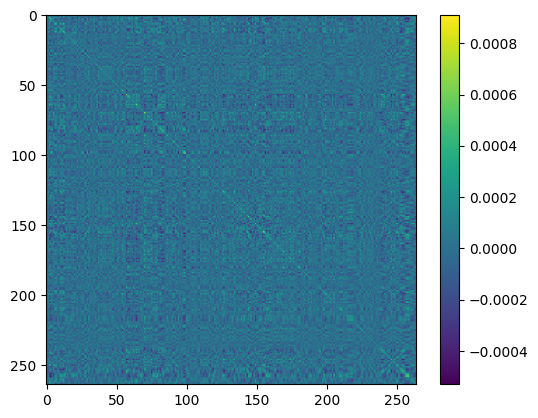

In [47]:
import matplotlib.pyplot as plt

# plt.imshow(fc[:,:,0].detach().cpu().numpy())
# plt.imshow(recon_fc[:,:,35].detach().cpu().numpy())
# plt.imshow(subEsav[:,:,0].detach().cpu().numpy())
plt.imshow(tst[:,:,35].detach().cpu().numpy())
plt.colorbar()
plt.show()

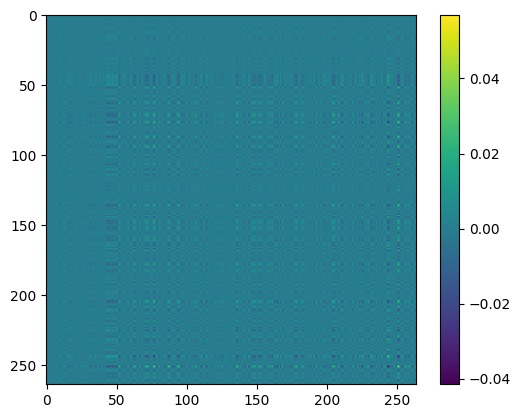

In [64]:
import matplotlib.pyplot as plt

plt.imshow(book[40].detach().cpu().numpy())
plt.colorbar()
plt.show()

In [127]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        self.Bs = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            B = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
            self.Bs.append(B)
        self.As = nn.ParameterList(self.As)
        self.Bs = nn.ParameterList(self.Bs)

    def forward(self):
        book = []
        for A,B in zip(self.As,self.Bs):
            AB = A.T@B
            book.append(AB)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, nmods, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, nt-1).float().cuda())

    def forward(self, sub, book):
        w = self.w[sub]
        return torch.einsum('pt,pab->abt', w, book)
    
def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_sub_ec(subts):
    return torch.einsum('at,bt->abt',subts[:,1:],subts[:,:-1])#*mask.unsqueeze(2)
    
# Timeseries
x = torch.from_numpy(ts[0]).float().cuda()
    
# Parameters
ntrain = 400
nbatch = 30
smooth_mult = 1
nEpochs = 50
pPeriod = 40

mseLoss = nn.MSELoss()
    
# Codebook and weights
lrc = LowRankCodes(300*[1])
ncodes = len(lrc.As)

lrw = LowRankWeights(ntrain, 1, ncodes, x.shape[-1])

# Optimizers
optim = torch.optim.Adam(itertools.chain(lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)
    
for epoch in range(nEpochs):
    suborder = np.arange(ntrain)
#     np.random.shuffle(suborder)
    for bstart in range(0,ntrain,nbatch):
        bend = bstart+nbatch
        if bend > ntrain:
            bend = ntrain
        optim.zero_grad()
        book = lrc()
        recon_loss = 0
        smooth_loss_fc = 0
        for subidx in range(bstart, bend):
            sub = suborder[subidx]
            xsub = get_sub_ec(x[sub])
            xhat = lrw(sub, book)
            recon_loss += get_recon_loss(xsub, xhat)
            smooth_loss_fc += smooth_mult*get_smooth_loss(xhat)
        recon_loss /= (bend-bstart)
        smooth_loss_fc /= (bend-bstart)
        totloss = recon_loss+smooth_loss_fc
        totloss.backward()
        optim.step()
        sched.step(totloss)
        if bstart % nbatch == 0:
            print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc]]} '
                  f'lr: {sched._last_lr}')

print('Complete')

0 0 recon: [0.010468007165772095, 2.227906779607515e-06] lr: [0.01]
0 30 recon: [0.010363359353313617, 2.2270896482644767e-06] lr: [0.01]
0 60 recon: [0.010735538169514608, 2.226878356336752e-06] lr: [0.01]
0 90 recon: [0.010327818552329785, 2.228667764162407e-06] lr: [0.01]
0 120 recon: [0.01174153221930267, 2.230756897432886e-06] lr: [0.01]
0 150 recon: [0.011190858991084613, 2.229927780219264e-06] lr: [0.01]
0 180 recon: [0.010415938152912632, 2.230142866965215e-06] lr: [0.01]
0 210 recon: [0.010906427294047859, 2.2285737742550087e-06] lr: [0.01]
0 240 recon: [0.01106642822033862, 2.2307040173567768e-06] lr: [0.01]
0 270 recon: [0.010954889043556676, 2.230750967927928e-06] lr: [0.01]
0 300 recon: [0.010330905214083518, 2.232418870424561e-06] lr: [0.01]
0 330 recon: [0.01089387410440232, 2.2335509541083692e-06] lr: [0.01]
0 360 recon: [0.010460171184736407, 2.234096786651098e-06] lr: [0.01]
0 390 recon: [0.011994967225837799, 2.2401567311360784e-06] lr: [0.01]
1 0 recon: [0.010467803

8 90 recon: [0.009365915777981636, 0.0011485764011433975] lr: [0.0075]
8 120 recon: [0.010647805133163437, 0.001500822060268741] lr: [0.0075]
8 150 recon: [0.009826150356716334, 0.0014563469433420228] lr: [0.0075]
8 180 recon: [0.00904094921310378, 0.0015317896267128123] lr: [0.0075]
8 210 recon: [0.009653883394452523, 0.0015792781172031414] lr: [0.0075]
8 240 recon: [0.009914553407317873, 0.001642739928120005] lr: [0.0075]
8 270 recon: [0.009677002414912489, 0.0019500857087529318] lr: [0.0075]
8 300 recon: [0.009240422848684452, 0.0016300248452423814] lr: [0.0075]
8 330 recon: [0.009257276062775, 0.0017136225865884928] lr: [0.0075]
8 360 recon: [0.009318708134426978, 0.001555442590789499] lr: [0.0075]
8 390 recon: [0.01099182196848063, 0.00215515298652237] lr: [0.0075]
9 0 recon: [0.009281023998987848, 0.0013490968756617418] lr: [0.0075]
9 30 recon: [0.009071930785718848, 0.0013537295647728517] lr: [0.0075]
9 60 recon: [0.0097265553504322, 0.001191209608904373] lr: [0.0075]
9 90 recon

16 90 recon: [0.009026248048952351, 0.001279329213665721] lr: [0.005625]
16 120 recon: [0.010334195839166208, 0.0015927254057879843] lr: [0.005625]
16 150 recon: [0.00947147004329802, 0.0014649225998558124] lr: [0.005625]
16 180 recon: [0.00869437629738971, 0.0014100562562267764] lr: [0.005625]
16 210 recon: [0.009367126816483612, 0.0014478290111799997] lr: [0.005625]
16 240 recon: [0.009697539314501973, 0.0013717332505152452] lr: [0.005625]
16 270 recon: [0.009419643165885429, 0.001535571724203543] lr: [0.005625]
16 300 recon: [0.008992011806420896, 0.001257339749136164] lr: [0.005625]
16 330 recon: [0.008822137138566104, 0.001568020322455159] lr: [0.005625]
16 360 recon: [0.009077649459867885, 0.0013546373411701975] lr: [0.005625]
16 390 recon: [0.009638077426854038, 0.002327443292653087] lr: [0.005625]
17 0 recon: [0.008974727359640618, 0.0013947927027873144] lr: [0.005625]
17 30 recon: [0.008800460706176983, 0.0014695212226545737] lr: [0.005625]
17 60 recon: [0.009420966235126747, 

24 60 recon: [0.008954389386668943, 0.001599400611123738] lr: [0.005625]
24 90 recon: [0.008554502208517854, 0.001522704936094493] lr: [0.005625]
24 120 recon: [0.00972298948662616, 0.0018150654067714482] lr: [0.005625]
24 150 recon: [0.008855808815917588, 0.0017299031727023256] lr: [0.005625]
24 180 recon: [0.008218092635245923, 0.0015889402582063847] lr: [0.005625]
24 210 recon: [0.008845416837192121, 0.0016372961214555805] lr: [0.005625]
24 240 recon: [0.009203865717970125, 0.0016041444812055618] lr: [0.005625]
24 270 recon: [0.008790194087562767, 0.001818816006008255] lr: [0.005625]
24 300 recon: [0.008531856340188493, 0.001481182709528232] lr: [0.005625]
24 330 recon: [0.00833126258492883, 0.0018290939487346483] lr: [0.005625]
24 360 recon: [0.008583632980457149, 0.0016234678587464131] lr: [0.005625]
24 390 recon: [0.00969129227141087, 0.003562332809288183] lr: [0.005625]
25 0 recon: [0.008483714764039356, 0.001655218199424336] lr: [0.005625]
25 30 recon: [0.008330023671471983, 0.

32 30 recon: [0.008037477066411622, 0.001820062322845625] lr: [0.005625]
32 60 recon: [0.008558991463483594, 0.0018041554030573228] lr: [0.005625]
32 90 recon: [0.008203591393086853, 0.0017058338001672945] lr: [0.005625]
32 120 recon: [0.009185208416203005, 0.002066012094243894] lr: [0.005625]
32 150 recon: [0.008421335826853156, 0.001965691653144485] lr: [0.005625]
32 180 recon: [0.007855314326125953, 0.0017714866233940415] lr: [0.005625]
32 210 recon: [0.00844687468872725, 0.0018382406417247164] lr: [0.005625]
32 240 recon: [0.008812480761945808, 0.0018295501075607252] lr: [0.005625]
32 270 recon: [0.008389491553555374, 0.0020310030039673104] lr: [0.005625]
32 300 recon: [0.008193226466220532, 0.0016568781437322896] lr: [0.005625]
32 330 recon: [0.007957843431066343, 0.0019704387301163343] lr: [0.005625]
32 360 recon: [0.008252838999977046, 0.0017950126157150218] lr: [0.005625]
32 390 recon: [0.00851036047530879, 0.0029020137078070727] lr: [0.005625]
33 0 recon: [0.008158425985306781

40 0 recon: [0.00796258090382725, 0.0018952562746462026] lr: [0.005625]
40 30 recon: [0.007805711900371659, 0.001888548645769583] lr: [0.005625]
40 60 recon: [0.008289787431223989, 0.0018999324505627818] lr: [0.005625]
40 90 recon: [0.00795884134085091, 0.0017951029289255997] lr: [0.005625]
40 120 recon: [0.008781637343509827, 0.0022194648686409235] lr: [0.005625]
40 150 recon: [0.008146688147256248, 0.002055762397547437] lr: [0.005625]
40 180 recon: [0.007607461396832083, 0.0018547877522510816] lr: [0.005625]
40 210 recon: [0.008179578272535192, 0.0019318860767534927] lr: [0.005625]
40 240 recon: [0.008522152793140803, 0.001953227675615027] lr: [0.005625]
40 270 recon: [0.00812563067218558, 0.002114039781095093] lr: [0.005625]
40 300 recon: [0.00795411810615627, 0.0017459786326140191] lr: [0.005625]
40 330 recon: [0.007726484506958809, 0.0020288263976007935] lr: [0.005625]
40 360 recon: [0.008033392428077792, 0.0018686079522624737] lr: [0.005625]
40 390 recon: [0.00843054482276166, 0.

48 0 recon: [0.007789007923805235, 0.0019760526511400606] lr: [0.005625]
48 30 recon: [0.0076355582611460195, 0.001961171234849228] lr: [0.005625]
48 60 recon: [0.00810636093934183, 0.0019779286940800776] lr: [0.005625]
48 90 recon: [0.007793146894893799, 0.0018711074290526525] lr: [0.005625]
48 120 recon: [0.00848911702213094, 0.002338629454766881] lr: [0.005625]
48 150 recon: [0.007946392110783681, 0.0021254474897222735] lr: [0.005625]
48 180 recon: [0.007429329816608665, 0.0019233300515210012] lr: [0.005625]
48 210 recon: [0.00799318406152641, 0.002003582585294472] lr: [0.005625]
48 240 recon: [0.008319104356259488, 0.0020430973781448082] lr: [0.005625]
48 270 recon: [0.007946774377250996, 0.0021778442953523567] lr: [0.005625]
48 300 recon: [0.007783013163352017, 0.0018179228891122181] lr: [0.005625]
48 330 recon: [0.007550077122208937, 0.0020902339443472076] lr: [0.005625]
48 360 recon: [0.007877294433989943, 0.0019239311590430437] lr: [0.005625]
48 390 recon: [0.008301448269298578

In [128]:
# Fast weight estimation for all subjects

with torch.no_grad():
    book = lrc()

    A = book.reshape(book.shape[0], -1).permute(1,0)
    AA = A.T@A
    codes = []

    for sub in range(x.shape[0]):
        B = get_sub_ec(x[sub]).reshape(-1, x.shape[-1]-1)
        AB = A.T@B
        C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
        codes.append(torch.from_numpy(C.detach().cpu().numpy()))
        if sub % 100 == 0:
            loss = mseLoss(A@C,B)**0.5
            print(f'Finished {sub} {loss}')
    
codes = torch.stack(codes)
print(codes.shape)

Finished 0 0.007367640733718872
Finished 100 0.0081642996519804
Finished 200 0.006105930544435978
Finished 300 0.007760424632579088
Finished 400 0.007457960397005081
Finished 500 0.0070837270468473434
Finished 600 0.008212029002606869
Finished 700 0.007407734170556068
Finished 800 0.00646112160757184
torch.Size([847, 300, 123])


In [137]:
ntrain = 800

codescuda = codes.float().cuda()
xps = torch.mean(codescuda, dim=-1) #ps.reshape(ps.shape[0],-1)
xps = torch.cat([xps, torch.ones(xps.shape[0], 1).float().cuda()], dim=1)
xtr = xps[:ntrain]
xt = xps[ntrain:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:ntrain]
yt = y_t[ntrain:]

w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr + 0.01*torch.eye(301).float().cuda(), xtr.T@ytr)

print(torch.mean((ytr-xtr@w)**2)**0.5)
print(torch.mean((yt-xt@w)**2)**0.5)

tensor(26.3278, device='cuda:0')
tensor(29.5524, device='cuda:0')
